# DLS Reading Python Code

# Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import calendar
from scipy.optimize import curve_fit
#from google.colab import drive
#drive.mount('/content/drive')

# LOAD & FORMAT DATA

In [13]:
# choose folder which includes hella DLS files
path = r'/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/Alison DLS'
files = os.listdir(path)

def check_composite(filename):
    if 'COMPOSITE' in filename:
            return filename

files = list(filter(check_composite, files))

# choose only the excel files
files_xls = [f for f in files if f[-4:] == 'xlsx']

# initiate new dataframe
df = pd.DataFrame()

# open each file and concatenate into df if sheetname is given below:
insheet = ["2023-01-27 304oi10 and 306o10 f",
            "2023-02-23 LUV",
            "2023-03-21 LUV",
            "2023-03-31",
            "2023-05-10",
            "2023-06-15 LNP pH 7.4",
            "2023-07-21 LUV + LNP",
            "2023-07-27 lnp"]

for f in files_xls:
    
    
    # open excel file
    xl = pd.ExcelFile(os.path.join(path,f))

    # read sheet names and find intersection with insheet list
    sheetlist = list(set(xl.sheet_names) & set(insheet))   

    for sheet_name in sheetlist:
        # open sheet and concatenate with file
        data = pd.read_excel(os.path.join(path,f), sheet_name, header=0)
        data["filename"] = f
        data["sheetname"] = sheet_name
        df = pd.concat([df,data])

## Format df

In [14]:
# remove any columns that include the word Zeta
df = df.drop(columns=df.filter(regex=(r"Zeta")).columns)

In [ ]:
# if no measurement date & time, fill with Jan 0, 2000
df["Measurement Date and Time"] = df["Measurement Date and Time"].fillna('Monday, January 1, 2000 12:00:00 AM')

In [16]:
# drop Record Number column
df.drop(columns="Record Number")

# reset index to be unique values
df.reset_index(drop=True, inplace=True)

# make new column called Record Number which includes just unique indices
df["Record Number"] = df.index.values

## Create size dataframe

In [17]:
size = df.filter(regex=r'Size').drop_duplicates().dropna().T.reset_index().rename(columns={0:"Diameter (nm)"})
size['DLS index'] = size['index'].str.findall(r'\d+').explode().astype(int)
size['Log Diameter'] = size["Diameter (nm)"].apply("log10")
size = size.drop(columns='index')
size

,Diameter (nm),DLS index,Log Diameter
0,0.4000,1,-0.397940
1,0.4632,2,-0.334231
2,0.5365,3,-0.270430
3,0.6213,4,-0.206699
4,0.7195,5,-0.142969
...,...,...,...
65,5560.0000,66,3.745075
66,6439.0000,67,3.808818
67,7456.0000,68,3.872506
68,8635.0000,69,3.936262


## Create intensity dataframe

In [24]:
intensity = df.filter(regex=r'Record Number|Intensities').set_index('Record Number').T
intensity['DLS index'] = pd.Series(intensity.index).str.findall(r'\d+').explode().values.astype(int)

# drop any rows for which there are nan values
intensity = intensity.dropna(axis=1)
intensity.head(3)

Record Number,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,DLS index
Intensities[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Intensities[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Intensities[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Create number dataframe

In [25]:
number = df.filter(regex=r'Record Number|Numbers').set_index('Record Number').T
number['DLS index'] = pd.Series(number.index).str.findall(r'\d+').explode().values

# drop any rows for which there are nan values
number = number.dropna(axis=1)
number.head(3)

Record Number,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,DLS index
Numbers[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Numbers[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Numbers[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Create volume dataframe

In [28]:
volume = df.filter(regex=r'Record Number|Volumes').set_index('Record Number').T
volume['DLS index'] = pd.Series(volume.index).str.findall(r'\d+').explode().values

# drop any rows for which there are nan values
volume = volume.dropna(axis=1)
volume.head(3)

Record Number,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,DLS index
Volumes[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Volumes[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Volumes[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Create info dataframe

In [76]:
df.columns.to_numpy()

array(['Measurement Date and Time', 'Record Number', 'Sample Name',
       'Sizes[1] (d.nm)', 'Sizes[2] (d.nm)', 'Sizes[3] (d.nm)',
       'Sizes[4] (d.nm)', 'Sizes[5] (d.nm)', 'Sizes[6] (d.nm)',
       'Sizes[7] (d.nm)', 'Sizes[8] (d.nm)', 'Sizes[9] (d.nm)',
       'Sizes[10] (d.nm)', 'Sizes[11] (d.nm)', 'Sizes[12] (d.nm)',
       'Sizes[13] (d.nm)', 'Sizes[14] (d.nm)', 'Sizes[15] (d.nm)',
       'Sizes[16] (d.nm)', 'Sizes[17] (d.nm)', 'Sizes[18] (d.nm)',
       'Sizes[19] (d.nm)', 'Sizes[20] (d.nm)', 'Sizes[21] (d.nm)',
       'Sizes[22] (d.nm)', 'Sizes[23] (d.nm)', 'Sizes[24] (d.nm)',
       'Sizes[25] (d.nm)', 'Sizes[26] (d.nm)', 'Sizes[27] (d.nm)',
       'Sizes[28] (d.nm)', 'Sizes[29] (d.nm)', 'Sizes[30] (d.nm)',
       'Sizes[31] (d.nm)', 'Sizes[32] (d.nm)', 'Sizes[33] (d.nm)',
       'Sizes[34] (d.nm)', 'Sizes[35] (d.nm)', 'Sizes[36] (d.nm)',
       'Sizes[37] (d.nm)', 'Sizes[38] (d.nm)', 'Sizes[39] (d.nm)',
       'Sizes[40] (d.nm)', 'Sizes[41] (d.nm)', 'Sizes[42] (d.nm)',
   

In [ ]:
df.filter(regex=r'Record Number|Volumes')

In [ ]:
df.filter(regex=r'Record Number|Volumes')

In [18]:
info = pd.DataFrame(df.loc[:,['Measurement Date and Time','Sample Name','Record Number']].copy(deep=True))
info['Triplicate'] = info['Sample Name'].str.strip().str[-1]
info['title'] = info['Sample Name'].str.rstrip(r'123 ')

# extract date and time information
info = info.join(pd.DataFrame(info["Measurement Date and Time"].str.findall(r'([A-Z][a-z]*), ([A-Z][a-z]*) (\d\d?), (\d{4}) (\d\d?:\d\d?:\d\d [AP]M)').explode().to_list(), columns=["day of week","month","day","year","time"]))

# replace string month to numerical month to be read by datetime function
d = dict((v,k) for k,v in enumerate(calendar.month_name))
info["month"] = info.month.map(d)

# convert columns to integer datatype
info["day"] = info["day"].astype(int)
info["month"] = info["month"].astype(int)
info["year"] = info["year"].astype(int)

# convert month/day/year into datetime format
info["date"] = pd.to_datetime(info.loc[:,["year","month","day"]])

# remove month/date/year columns
info.drop(columns=['year','month','day','day of week'], inplace=True)

info.head()

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date
0,"Friday, July 21, 2023 5:20:15 PM",CF POPG LUV 1X 1,0,1,CF POPG LUV 1X,5:20:15 PM,2023-07-21
1,"Friday, July 21, 2023 5:22:48 PM",CF POPG LUV 1X 2,1,2,CF POPG LUV 1X,5:22:48 PM,2023-07-21
2,"Friday, July 21, 2023 5:25:21 PM",CF POPG LUV 1X 3,2,3,CF POPG LUV 1X,5:25:21 PM,2023-07-21
3,"Friday, July 21, 2023 5:59:43 PM",R18 POPC LUV pH 5.5 0.05X 1,3,1,R18 POPC LUV pH 5.5 0.05X,5:59:43 PM,2023-07-21
4,"Friday, July 21, 2023 6:01:46 PM",R18 POPC LUV pH 5.5 0.05X 2,4,2,R18 POPC LUV pH 5.5 0.05X,6:01:46 PM,2023-07-21


### Create samples dataframe

In [19]:
samples = info.loc[:,["title","date"]].drop_duplicates()

In [20]:
samples["id"] = np.arange(0,samples.shape[0])
samples.head()

,title,date,id
0,CF POPG LUV 1X,2023-07-21,0
3,R18 POPC LUV pH 5.5 0.05X,2023-07-21,1
6,306oi10 LNP pH 5.5 0.1X,2023-07-21,2
9,306o10 LNP pH 7.4 0.1X,2023-07-21,3
12,306o10 LNP pH 5.5 0.1X with Liposomes_1x_PBS_p...,2023-07-21,4


### Compute days since first sample for each unique title

In [21]:
# new startdate pivot table with earliest date for each unique title
startdate = pd.pivot_table(data=samples,
               index="title",
               values="date",
               aggfunc="min").rename(columns={"date" : "start date"})

In [22]:
# add back in to samples and compute days since 'start date'
samples = samples.merge(startdate, left_on="title",right_on="title")
samples["days since"] = samples["date"] - samples["start date"]
samples["days since"] = samples["days since"].apply(lambda x: x.days)

In [23]:
# return info back to `info` dataframe
info = info.merge(samples, 
           left_on=["title","date"],
           right_on=["title","date"]
          )
info.head()

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date,id,start date,days since
0,"Friday, July 21, 2023 5:20:15 PM",CF POPG LUV 1X 1,0,1,CF POPG LUV 1X,5:20:15 PM,2023-07-21,0,2023-02-22,149
1,"Friday, July 21, 2023 5:22:48 PM",CF POPG LUV 1X 2,1,2,CF POPG LUV 1X,5:22:48 PM,2023-07-21,0,2023-02-22,149
2,"Friday, July 21, 2023 5:25:21 PM",CF POPG LUV 1X 3,2,3,CF POPG LUV 1X,5:25:21 PM,2023-07-21,0,2023-02-22,149
3,"Friday, July 21, 2023 5:59:43 PM",R18 POPC LUV pH 5.5 0.05X 1,3,1,R18 POPC LUV pH 5.5 0.05X,5:59:43 PM,2023-07-21,1,2023-07-21,0
4,"Friday, July 21, 2023 6:01:46 PM",R18 POPC LUV pH 5.5 0.05X 2,4,2,R18 POPC LUV pH 5.5 0.05X,6:01:46 PM,2023-07-21,1,2023-07-21,0


## Join `intensity`, `number`, `volume`, `size`, and `info` to `df_main`

In [32]:
df_main = intensity.melt(id_vars='DLS index', value_vars=intensity.columns, value_name='Intensity %')
print(df_main.shape)

(13930, 3)


In [33]:
df_main = df_main.join(number.melt(id_vars='DLS index', value_vars=number.columns, value_name='Number %').loc[:,"Number %"])
print(df_main.shape)

(13930, 4)


In [34]:
df_main = df_main.join(volume.melt(id_vars='DLS index', value_vars=volume.columns, value_name='Volume %').loc[:,"Volume %"])
print(df_main.shape)

(13930, 5)


In [35]:
df_main = df_main.merge(size, left_on="DLS index", right_on="DLS index")
print(df_main.shape)

(13930, 7)


In [36]:
df_main = df_main.merge(info, left_on="Record Number", right_on="Record Number")
print(df_main.shape)

(13930, 16)


## Extract LUV/LNP Parameters from Title
fluorophore, LUV, LNP, lipid, lipidoid, pH

In [37]:
df_main["LUV"] = df_main["title"].str.count(r'LUV')

In [38]:
df_main["LNP"] = df_main["title"].str.count(r'LNP')

In [39]:
df_test = df_main["title"].str.findall(r'R18 \+ CF|R18|CF').explode()
df_test = df_test[~df_test.index.duplicated(keep='first')]
df_main["fluorophore"] = df_test

In [40]:
df_main["lipid"] = df_main["title"].str.findall(r'(POPC|POPG)').explode()
df_main["lipid"] = df_main["lipid"].fillna('POPC')

In [41]:
df_main["lipidoid"] = df_main["title"].str.findall(r'\d{3}\w{1,2}10').explode()

In [42]:
df_main["pH"] = df_main["title"].str.findall(r'pH (5.5|7.4)').explode()
df_main["pH"] = df_main["pH"].fillna('7.4')

In [43]:
df_main["Triton"] = df_main["title"].str.count(r'Triton')

# CALCULATIONS

## Compute Peak Diameter (mode) for each `id` 

In [54]:
# aggfunc finds the index of the maximum value for intensity and number columns, then uses index to find the diameter at which the max is found
df_pivot = pd.pivot_table(data=df_main,
               index='id',
               values = ["Intensity %","Number %","Volume %"],
               aggfunc = [lambda x: df_main.loc[x.idxmax(0),"Diameter (nm)"]]
              )

df_pivot.head(2)

<lambda>                  
   Intensity % Number % Volume %
id                              
0        91.28    58.77    68.06
1       122.40    78.82   105.70

In [55]:
# format column names
df_pivot.columns = ["Peak Diameter by " + a[1] for a in df_pivot.columns.to_flat_index()]
df_pivot.head(2)

,Peak Diameter by Intensity %,Peak Diameter by Number %,Peak Diameter by Volume %
id,,,
0,91.28,58.77,68.06
1,122.40,78.82,105.70


In [56]:
# merge back in to df_main
df_main = df_main.merge(df_pivot, left_on="id", right_on="id")
df_main.head()

,DLS index,Record Number,Intensity %,Number %,Volume %,Diameter (nm),Log Diameter,Measurement Date and Time,Sample Name,Triplicate,...,pH,Triton,Peak Diameter by Intensity %_x,Peak Diameter by Number %_x,Peak Diameter by Intensity %_y,Peak Diameter by Number %_y,Peak Diameter by Volume %_x,Peak Diameter by Intensity %,Peak Diameter by Number %,Peak Diameter by Volume %_y
0,1,0,0.0,0.0,0.0,0.4000,-0.397940,"Friday, July 21, 2023 5:20:15 PM",CF POPG LUV 1X 1,1,...,7.4,0,91.28,58.77,91.28,58.77,68.06,91.28,58.77,68.06
1,2,0,0.0,0.0,0.0,0.4632,-0.334231,"Friday, July 21, 2023 5:20:15 PM",CF POPG LUV 1X 1,1,...,7.4,0,91.28,58.77,91.28,58.77,68.06,91.28,58.77,68.06
2,3,0,0.0,0.0,0.0,0.5365,-0.270430,"Friday, July 21, 2023 5:20:15 PM",CF POPG LUV 1X 1,1,...,7.4,0,91.28,58.77,91.28,58.77,68.06,91.28,58.77,68.06
3,4,0,0.0,0.0,0.0,0.6213,-0.206699,"Friday, July 21, 2023 5:20:15 PM",CF POPG LUV 1X 1,1,...,7.4,0,91.28,58.77,91.28,58.77,68.06,91.28,58.77,68.06
4,5,0,0.0,0.0,0.0,0.7195,-0.142969,"Friday, July 21, 2023 5:20:15 PM",CF POPG LUV 1X 1,1,...,7.4,0,91.28,58.77,91.28,58.77,68.06,91.28,58.77,68.06


## Compute weighted average intensity and number

In [57]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %', 'Volume %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %_x',
       'Peak Diameter by Number %_x', 'Peak Diameter by Intensity %_y',
       'Peak Diameter by Number %_y', 'Peak Diameter by Volume %_x',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %',
       'Peak Diameter by Volume %_y'],
      dtype='object')

In [58]:
# prepare temporary dataframe for calculation
df_rn = pd.DataFrame(df_main["Record Number"].drop_duplicates()).set_index("Record Number")

# for each unique record number, compute the weighted average intensity and number
for rn in df_rn.index:
    rn_sum_prod_int = df_main.loc[df_main["Record Number"] == rn].loc[:,["Intensity %","Diameter (nm)"]].product(axis=1).sum()
    rn_sum_prod_num = df_main.loc[df_main["Record Number"] == rn].loc[:,["Number %","Diameter (nm)"]].product(axis=1).sum()
    rn_sum_weights_int = df_main.loc[df_main["Record Number"] == rn].loc[:,["Intensity %"]].sum().values
    rn_sum_weights_num = df_main.loc[df_main["Record Number"] == rn].loc[:,["Number %"]].sum().values

    # assign value in df_rn
    df_rn.loc[rn,"Weighted Average Intensity"] = rn_sum_prod_int / rn_sum_weights_int
    df_rn.loc[rn,"Weighted Average Number"] = rn_sum_prod_num / rn_sum_weights_num

In [59]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %', 'Volume %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %_x',
       'Peak Diameter by Number %_x', 'Peak Diameter by Intensity %_y',
       'Peak Diameter by Number %_y', 'Peak Diameter by Volume %_x',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %',
       'Peak Diameter by Volume %_y'],
      dtype='object')

## Fit Curves to Gaussian and Extract parameters

### Generate fitted parameters (a, x0, sigma)

In [60]:
# Define Gaussian function that we will fit to
def Gauss(x, a, x0, sigma):
    # a = maximum 
    # x0 = mean
    # sigma = standard of deviation
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# initial guess for data
p0_guess = p0=[10,2,1]

In [61]:
for rn in df_rn.index:
    
    for datatype in ["Intensity","Number"]:

        # extract dataframe for this record number
        df_temp = df_main.loc[df_main["Record Number"]==rn].loc[:,["Log Diameter",datatype + " %"]].copy(deep=True)

        # Execute Curve Fit
        popt, pcov = curve_fit(Gauss, 
                               df_temp["Log Diameter"].values, 
                               df_temp[datatype + " %"].values,
                               p0=p0_guess)

        # load Optimized values into df_rn
        df_rn.loc[rn,["a "+datatype,"log10 x0 "+datatype,"log10 sigma "+datatype]] = popt
        
        # generate new fitted data
        yfit = Gauss(df_temp["Log Diameter"].values, 
                     popt[0], popt[1], popt[2])
        
        # load into df_temp, then join with df_main
        df_main.loc[df_temp.index,"Fitted "+datatype+" %"] = yfit

In [62]:
# calculate and load confidence interval data into df_rn
for datatype in ["Intensity","Number"]:
    # convert x0 and sigma back to linear space
    df_rn.loc[:,"x0 "+datatype]    = np.power(10,df_rn.loc[:,"log10 x0 " + datatype])
    df_rn.loc[:,"sigma "+datatype] = np.power(10,df_rn.loc[:,"log10 sigma " + datatype])

    # calculate lower and upper bounds of confidence interval
    df_rn.loc[:,"lower "+datatype] = np.power(10, df_rn.loc[:,"log10 x0 " + datatype] - df_rn.loc[:,"log10 sigma " + datatype])
    df_rn.loc[:,"upper "+datatype] = np.power(10, df_rn.loc[:,"log10 x0 " + datatype] + df_rn.loc[:,"log10 sigma " + datatype])

    # calculate lower and upper error bars of confidence interval
    df_rn.loc[:,"lower err "+datatype] = df_rn.loc[:,"x0 "+datatype]      - df_rn.loc[:,"lower "+datatype]
    df_rn.loc[:,"upper err "+datatype] = df_rn.loc[:,"upper "+datatype] - df_rn.loc[:,"x0 "+datatype]

In [63]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %', 'Volume %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %_x',
       'Peak Diameter by Number %_x', 'Peak Diameter by Intensity %_y',
       'Peak Diameter by Number %_y', 'Peak Diameter by Volume %_x',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %',
       'Peak Diameter by Volume %_y', 'Fitted Intensity %', 'Fitted Number %'],
      dtype='object')

In [64]:
# merge all that new confidence interval information into df_main
df_main = df_main.merge(df_rn, left_on="Record Number", right_on=df_rn.index)

In [65]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %', 'Volume %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %_x',
       'Peak Diameter by Number %_x', 'Peak Diameter by Intensity %_y',
       'Peak Diameter by Number %_y', 'Peak Diameter by Volume %_x',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %',
       'Peak Diameter by Volume %_y', 'Fitted Intensity %', 'Fitted Number %',
       'Weighted Average Intensity', 'Weighted Average Number', 'a Intensity',
       'log10 x0 Intensity', 'log10 sigma Intensity', 'a Number',
       'log10 x0 Number', 'log10 sigma Number', 'x0 Intensity',
       'sigma Intensity', 'lower Intensity', 'upper Intensity',
       'lower err Intensity', 'upper err Intensity', 'x0 Number',
       'sigma Numbe

# SAVE dataframe!

In [ ]:
df_main.to_excel('data/df_main.xlsx', sheet_name='all data')

In [ ]:
df_main.columns

# LOAD DATAFRAME

In [2]:
df_main = pd.read_excel('data/df_main.xlsx', sheet_name='all data')

# PLOTTING

## Bar Graphs of Peak, Weighted Mean Diameter, and Fitted Mean Diameter

In [67]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %', 'Volume %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %_x',
       'Peak Diameter by Number %_x', 'Peak Diameter by Intensity %_y',
       'Peak Diameter by Number %_y', 'Peak Diameter by Volume %_x',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %',
       'Peak Diameter by Volume %_y', 'Fitted Intensity %', 'Fitted Number %',
       'Weighted Average Intensity', 'Weighted Average Number', 'a Intensity',
       'log10 x0 Intensity', 'log10 sigma Intensity', 'a Number',
       'log10 x0 Number', 'log10 sigma Number', 'x0 Intensity',
       'sigma Intensity', 'lower Intensity', 'upper Intensity',
       'lower err Intensity', 'upper err Intensity', 'x0 Number',
       'sigma Numbe

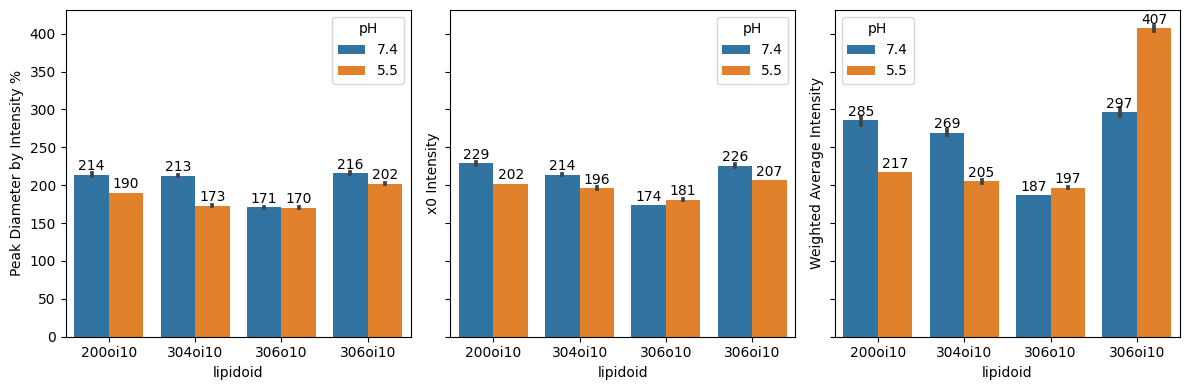

In [66]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

var_id = 0

for variable in ['Peak Diameter by Intensity %', 'x0 Intensity', 'Weighted Average Intensity']:

    # plot peak diameter by intensity
    sns.barplot(data=df_main.sort_values(by="lipidoid"),
                x="lipidoid",
                y=variable,
                hue="pH",
                ax=ax[var_id])
    
    for c in ax[var_id].containers:
        # set the bar label
        ax[var_id].bar_label(c, fmt='%.0f', label_type='edge', padding=1)

    #ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
    #ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
    #plt.xticks(rotation = 45)
    var_id += 1
    
    plt.tight_layout()

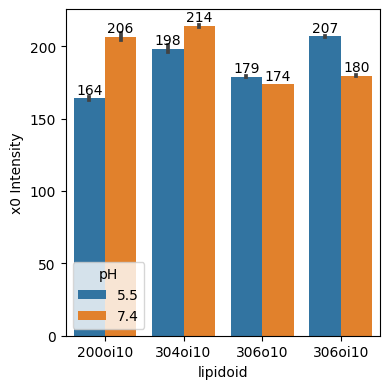

In [30]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

# plot peak diameter by intensity
sns.barplot(data=df_main.sort_values(by="lipidoid"),
            x="lipidoid",
            y='x0 Intensity',
            hue="pH",
            ax=ax)

for c in ax.containers:
    # set the bar label
    ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)
    c.yerr=[100, 200, 300, 400]
    

#ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
#ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
#plt.xticks(rotation = 45)

plt.tight_layout()

In [11]:
ax.get_xticks()

array([0, 1, 2, 3])

# SCRAP WORK

## Plot LUV by type of lipid for samples with no Triton

POPC
POPG


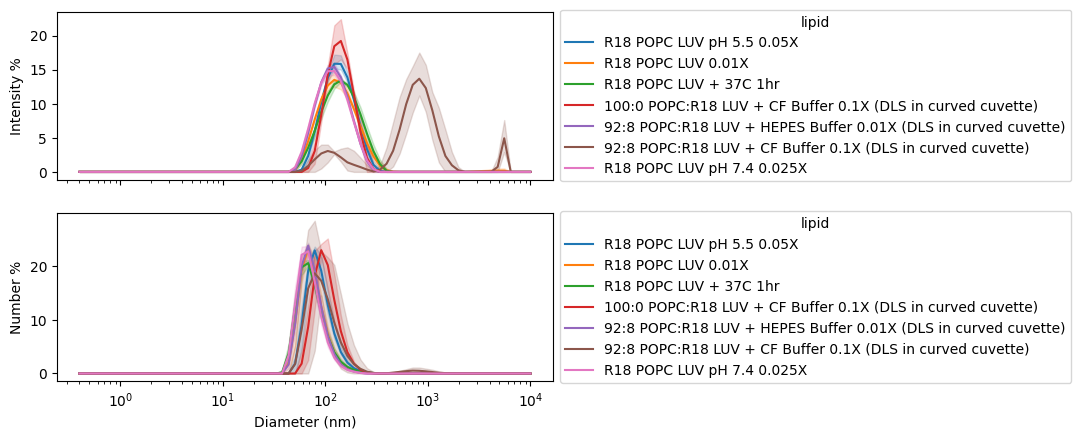

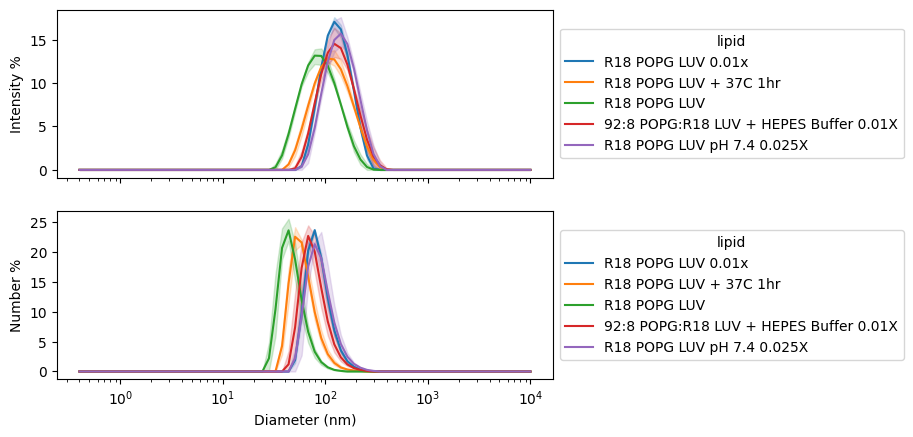

In [3]:
LUV = 1
lipid = "POPC"
fluorophore = "R18"
pH = "5.5"
Triton = 0

temp_data = df_main[(df_main["LUV"] == LUV) &
                    (df_main["fluorophore"] == fluorophore) &
                    #(df_main["pH"] == pH) &
                    (df_main["Triton"] == Triton)]

for lipid in temp_data["lipid"].dropna().unique():
    print(lipid)
    
    fig, ax = plt.subplots(2,1, sharex=True)

    sns.lineplot(data=temp_data[temp_data["lipid"] == lipid],
                 x="Diameter (nm)",
                 y="Intensity %",
                 hue="title",
                 ax=ax[0])

    sns.lineplot(data=temp_data[temp_data["lipid"] == lipid],
                 x="Diameter (nm)",
                 y="Number %",
                 hue="title",
                 ax=ax[1])

    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipid")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipid")

    ax[0].set_xscale('log')

In [ ]:
fig, ax = plt.subplots(2,1, sharex=True)

temp_data = df_main[df_main['lipidoid'].notna()]

sns.lineplot(data=temp_data,
             x="Diameter (nm)",
             y="Intensity %",
             hue="lipidoid",
             style="pH",
             ax=ax[0])

sns.lineplot(data=temp_data,
             x="Diameter (nm)",
             y="Number %",
             hue="lipidoid",
             style="pH",
             ax=ax[1])

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipidoid")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipidoid")

ax[0].set_xscale('log')

## Bargraph of x0 using fitted error bars

### Find one record number which is lipidoid 200oi10 and make a bar graph

In [ ]:
df_main.columns

In [ ]:
df_main.loc[df_main["Record Number"]==123].loc[:,["lipidoid","x0 Intensity","lower err Intensity","upper err Intensity"]].drop_duplicates().values

In [ ]:
x = df_main.loc[df_main["Record Number"]==123].loc[:,"lipidoid"].drop_duplicates().values
y = df_main.loc[df_main["Record Number"]==123].loc[:,"x0 Intensity"].drop_duplicates().values
y = y[0]

yerr = df_main.loc[df_main["Record Number"]==123].loc[:,["lower err Intensity","upper err Intensity"]].drop_duplicates().values
yerr = yerr[0]
yerr = yerr.reshape(2,1)

In [ ]:
print(x)
print(y)
print(yerr)

In [ ]:
np.shape(yerr)

In [ ]:
fig, ax = plt.subplots()

ax.bar(0, y, yerr=yerr, tick_label=123, capsize=10)
ax.set_yscale('log')

## one bar for each record number, different colors for pH

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

x_start = 0

color_dict = {"5.5" : "blue",
              "7.4" : "orange"}

xticks = []
xticklabels = []

for pH in ["7.4","5.5"]:

    rn_list = df_main.loc[(df_main["lipidoid"]=="200oi10") &
                          (df_main["pH"] == pH)]["Record Number"].unique()
    x = x_start + np.arange(0,len(rn_list))
    y = df_main.loc[df_main["Record Number"].isin(rn_list)].loc[:,"x0 Intensity"].drop_duplicates().values
    yerr = df_main.loc[df_main["Record Number"].isin(rn_list)].loc[:,["lower err Intensity","upper err Intensity"]].drop_duplicates().values.T

    ax.bar(x, y, yerr=yerr, 
           tick_label=rn_list, 
           capsize=5,
           color=color_dict[pH])
    
    # reset
    x_start = np.max(x)+1
    xticks = np.append(xticks, ax.get_xticks())
    xticklabels = np.append(xticklabels, rn_list)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
...

# print all titles with rn
df_main.loc[df_main["lipidoid"]=="200oi10"].loc[:,["Record Number","pH","title","Measurement Date and Time"]].drop_duplicates()

In [ ]:
# for each lipidoid, extract x0, and lower/upper sigma, and AVERAGE
pd.pivot_table(data=df_main,
               index=["lipidoid","pH"],
               values=["x0 Intensity","lower err Intensity","upper err Intensity"],
               aggfunc="mean")

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))

# plot peak diameter by intensity

sns.barplot(data=df_main.sort_values(by="lipidoid"),
            x="lipidoid",
            y="Weighted Average Intensity_x",
            hue="pH",
            ax=ax)

for c in ax.containers:
    # set the bar label
    ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)

#ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
#ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
#plt.xticks(rotation = 45)
var_id += 1

plt.tight_layout()

# Plot spectra by lipidoid using seaborn

In [ ]:
fig, ax = plt.subplots(2, sharex=True)

# plot intensity data

sns.lineplot(df_main,
             x="Diameter (nm)",
             y="Intensity %",
             hue="lipidoid",
             style="pH",
             ax=ax[0])

# plot number data

sns.lineplot(df_main,
             x="Diameter (nm)",
             y="Number %",
             hue="lipidoid",
             style="pH",
             ax=ax[1])

# format axes

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_ylabel('Intensity %')
ax[1].set_ylabel('Number %')

ax[0].set_xlabel('Diameter (nm)')

# format legend

ax[1].legend()

    
plt.tight_layout()

In [ ]:
N = len(df_main["lipidoid"].unique())

fig, ax = plt.subplots(N,2, figsize=(20,N*3))

ax_id = 0

for lipidoid in df_main["lipidoid"].unique():
    
    # plot intensity data
    
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Intensity %",
                 label="Raw Data",
                 hue="pH",
                 ax=ax[ax_id,0])
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Fitted Intensity %",
                 label="Fitted Data",
                 hue="pH",
                 linestyle="dashed",
                 ax=ax[ax_id,0])

    # plot number data
    
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Number %",
                 label="Raw Data",
                 hue="pH",
                 ax=ax[ax_id,1])
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Fitted Number %",
                 label="Fitted Data",
                 hue="pH",
                 linestyle="dashed",
                 ax=ax[ax_id,1])

    # format axes
    
    ax[ax_id,0].set_xscale('log')
    ax[ax_id,1].set_xscale('log')
    
    ax[ax_id,0].set_title(lipidoid)
    
    ax[ax_id,0].set_ylabel('Intensity %')
    ax[ax_id,1].set_ylabel('Number %')
    
    ax[ax_id,0].set_xlabel('Diameter (nm)')
    ax[ax_id,1].set_xlabel('Diameter (nm)')
    
    # format legend
    
    ax[ax_id,1].legend()
    
    # format text
    '''
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))
    '''
    
    ax_id += 1
    
plt.tight_layout()

# Plot spectra by lipidoid using matplotlib

In [ ]:
N = len(df_main["lipidoid"].unique())

fig, ax = plt.subplots(N,2, figsize=(20,N*3))

ax_id = 0

for lipidoid in df_main["lipidoid"].unique():
    
    # plot intensity data
    
    ax[ax_id,0].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                   df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Intensity %"],
                   label="Raw Data")
    ax[ax_id,0].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Fitted Intensity %"],
                  label="Fitted Data")
    
    # plot number data
    
    ax[ax_id,1].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Number %"],
                  label="Raw Data")
    ax[ax_id,1].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Fitted Number %"],
                  label="Fitted Data")

    # format axes
    
    ax[ax_id,0].set_xscale('log')
    ax[ax_id,1].set_xscale('log')
    
    ax[ax_id,0].set_title(lipidoid)
    
    ax[ax_id,0].set_ylabel('Intensity %')
    ax[ax_id,1].set_ylabel('Number %')
    
    ax[ax_id,0].set_xlabel('Diameter (nm)')
    ax[ax_id,1].set_xlabel('Diameter (nm)')
    
    # format legend
    
    ax[ax_id,1].legend()
    
    # format text
    '''
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))
    '''
    
    ax_id += 1
    
plt.tight_layout()

## Plot fitted and raw data for every record number

In [ ]:
'''
N = len(df_main["Record Number"].unique())

fig, ax = plt.subplots(N,2, figsize=(8,N*4))

for rn in df_main["Record Number"].unique():
    
    # plot intensity data
    
    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Rrn*4ecord Number"]==rn].loc[:,"Intensity %"],
                  label="Raw Data")
    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Fitted Intensity %"],
                  label="Fitted Data")

    # plot number data
    
    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Number %"],
                  label="Raw Data")
    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Fitted Number %"],
                  label="Fitted Data")

    # format axes
    
    ax[rn-1,0].set_xscale('log')
    ax[rn-1,1].set_xscale('log')
    
    ax[rn-1,0].set_title('Record Number '+str(rn))
    
    ax[rn-1,0].set_ylabel('Intensity %')
    ax[rn-1,1].set_ylabel('Number %')
    
    ax[rn-1,0].set_xlabel('Diameter (nm)')
    ax[rn-1,1].set_xlabel('Diameter (nm)')
    
    # format text
    
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))

    plt.tight_layout()
'''

#  Plot specific items

# R18 POPC LUV by pH

In [ ]:
keeptitles = ["R18 POPC LUV pH 5.5 0.05X",
              "R18 POPC LUV pH 7.4 0.025X"]
             #"R18 POPC LUV 0.01X",]

In [ ]:
df_keep = df_main.loc[df_main["title"].isin(keeptitles)]

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=True)

sns.lineplot(data=df_keep,
             x="Diameter (nm)",
             y="Intensity %",
             hue="pH",
             ax=ax[0])

sns.lineplot(data=df_keep,
             x="Diameter (nm)",
             y="Number %",
             hue="pH",
             ax=ax[1])

ax[0].set_xscale('log')

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=True)

sns.barplot(data=df_keep,
             x="pH",
             y="x0 Intensity",
             ax=ax[0])

sns.barplot(data=df_keep,
             x="pH",
             y="x0 Number",
             ax=ax[1])

for c in ax[0].containers:
    # set the bar label
    ax[0].bar_label(c, fmt='%.0f', label_type='edge', padding=1)


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

var_id = 0

for variable in ['Peak Diameter by Intensity %', 'x0 Intensity', 'Weighted Average Intensity_x']:

    # plot peak diameter by intensity
    sns.barplot(data=df_keep,
                x="pH",
                y=variable,
               ax=ax[var_id])

    #ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
    #ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
    #plt.xticks(rotation = 45)
    var_id += 1
    
    plt.tight_layout()

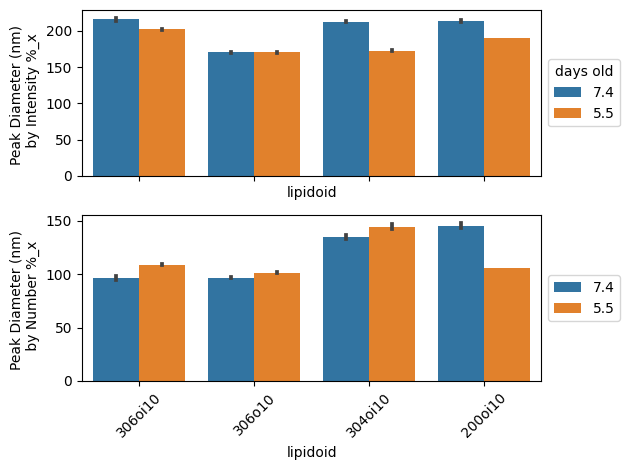

In [53]:
fig, ax = plt.subplots(2, sharex=True)

# plot peak diameter by intensity
sns.barplot(data=df_main,
            x="lipidoid",
            y="Peak Diameter by Intensity %_x",
            hue="pH",
           ax=ax[0])

ax[0].set_ylabel('Peak Diameter (nm) \n by Intensity %_x')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

# plot peak diameter by number
sns.barplot(data=df_main,
            x="lipidoid",
            y="Peak Diameter by Number %_x",
            hue="pH",
            ax=ax[1])

ax[1].set_ylabel('Peak Diameter (nm) \n by Number %_x')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation = 45)

plt.tight_layout()